In [1]:
# Code outline:
# 1. Indoor system - data:
#   a. Read data and parameters
#   b. process data (measurements)
# 2. Outdoor system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light HOBO data
# 3. Offshore system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light IMS data
# 4. Calculate model results for:
#   a. Indoor system
#   b. Outdoor system
#   c. Offshore system
# 5. Calculate errors in the combined df
# df_combined structure:
#System, time, m_exp, m_mod, m_SRE,Nint_exp, Nint_mod, Nint_SRE Next_exp, Next_mod, Next_SRE
# 6... minimize errors?

In [2]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

pandas version is 1.0.1


In [3]:
# Functions for optimization (i.e producing random parametric combination)
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.linear_model import LinearRegression

In [4]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import indoor data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Weighing,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,NaN,NaN,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,NaN,NaN,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,NaN,NaN,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN


In [5]:
# b. process data (indoor measurements)

    # 1. Convert Time into hours
T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

    # 2. Make a temp DF (df2_temp) by filtering the original df - remove 'wierd' results (i.e sporulation) 

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')&(df2.Comment != 'Exclude')&(df2.Duration == 168)]
df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
29,11.7,1,1,2.0,f,"2019,3,19,13,0","2019,3,26,12,0","2019,4,2,12,0",0.294,5.1,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,335
30,12.7,1,2,2.0,f,"2019,3,19,13,0","2019,3,26,12,0","2019,4,2,12,0",0.213,5.2,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,144.7,5,4,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.426,5.0,...,0.0,2.0,500.0,168.0,1000.0,No,NaN,NaN,NaN,501
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,5.0,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,5.0,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,5.0,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501


In [6]:
# 4. Calculate model results for:
#   a. Indoor system
    # I. Produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment

In [7]:
df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Trimming,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,165
29,11.7,1,1,2.0,f,"2019,3,19,13,0","2019,3,26,12,0","2019,4,2,12,0",0.294,5.1,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,335
30,12.7,1,2,2.0,f,"2019,3,19,13,0","2019,3,26,12,0","2019,4,2,12,0",0.213,5.2,...,0.0,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,144.7,5,4,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.426,5.0,...,0.0,2.0,500.0,168.0,1000.0,No,NaN,NaN,NaN,501
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,5.0,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,5.0,...,0.0,3.0,500.0,168.0,1500.0,No,NaN,NaN,NaN,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,5.0,...,0.0,5.0,200.0,168.0,1000.0,No,NaN,NaN,NaN,501


In [8]:
# II. Make a filtered array including only times of empiric measurement (remove from array results from times in which data was not measured)
# III. Add relevant columns from df2_temp and the model results to a new df_combined

In [9]:
#X = param_values[Y3.tolist().index(min(Y3))].tolist()
X = [0.03812255859375,
 0.003099609375,
 4.12744140625,
 1.116259765625,
 0.013515136718750001,
 13.291015625,
 68.65234375,
 32.07275390625,
 1.690185546875,
 0.0499853515625,
 6.2646484375,
 21.396484375,
 49.1650390625,
 18.1494140625,
 33.6220703125,
 5.24560546875]

In [10]:
miu = X[0]
lossess20 = X[1]
Nintmax = X[2]
Nintcrit = X[3]
dNextoutdt = X[4]
Ks = X[5]
Vmax = X[6]
KI = X[7]
K0 = X[8]
Ka = X[9]
Smin = X[10]
Sopt = X[11]
Smax = X[12]
Topt = X[13]
Tmax = X[14]
n = X[15]

In [11]:
miu = 0.04 #0.046
losses20 = 0.004 #0.005
Nintmax = 4.5 #4.25
Nintcrit = 2 #2 #3.7
dNextoutdt = 0.01 #0 #0.04
Ks = 15.5 #25.8 #14 #24.8
Vmax = 93.7 #53 # low because of nitrate
KI = 16 #15.2 #18 #20 #139
K0 = 2.4 #1.5 #1.7
Ka = 0.12 #0.15 #0.127
Smin = 0 #2.5
Sopt = 28 #18
Smax = 50 #45
Topt = 18 #22.2  #21.9 #18
Tmax = 35.9 #34.4
n = 5.1 #2
Tmin = 4


Treatment: 1000/1/168
Number of samples:
m: 27 Nint: 19 Next: 26
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration

Treatment: 500/2/168
Number of samples:
m: 66 Nint: 37 Next: 90
3.5
0.0
Starting point
84.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
252.0
Period
336.0
Duration
420.0
Period

Treatment: 500/3/168
Number of samples:
m: 18 Nint: 12 Next: 18
2.3333333333333335
0.0
Starting point
56.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


112.0
Period
168.0
Duration
224.0
Period
280.0
Period
336.0
Duration
392.0
Period
448.0
Period

Treatment: 2000/1/168
Number of samples:
m: 0 Nint: 0 Next: 0
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration

Treatment: 200/5/168
Number of samples:
m: 0 Nint: 0 Next: 0
1.4
0.0
Starting point
34.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


68.0
Period
102.0
Period
136.0
Period
170.0
Duration
204.0
Period
238.0
Period
272.0
Period
306.0
Period
340.0
Duration
374.0
Period
408.0
Period
442.0
Period
476.0
Period


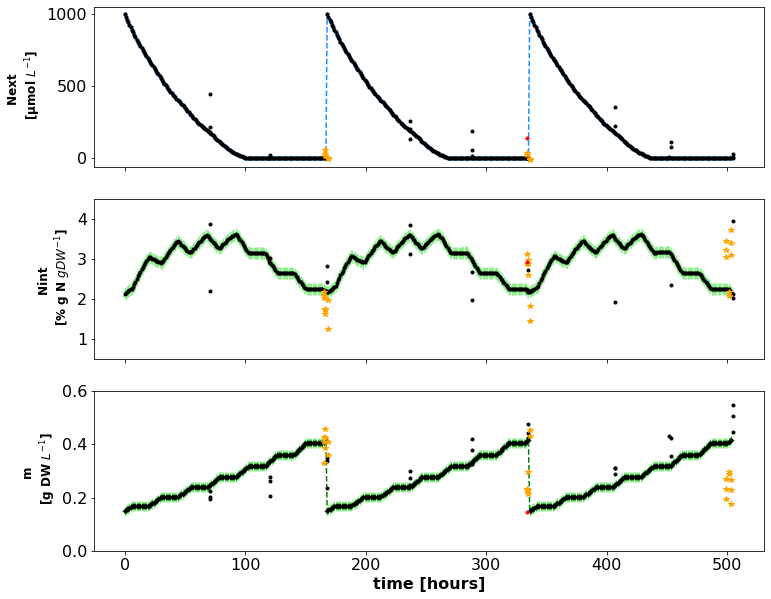

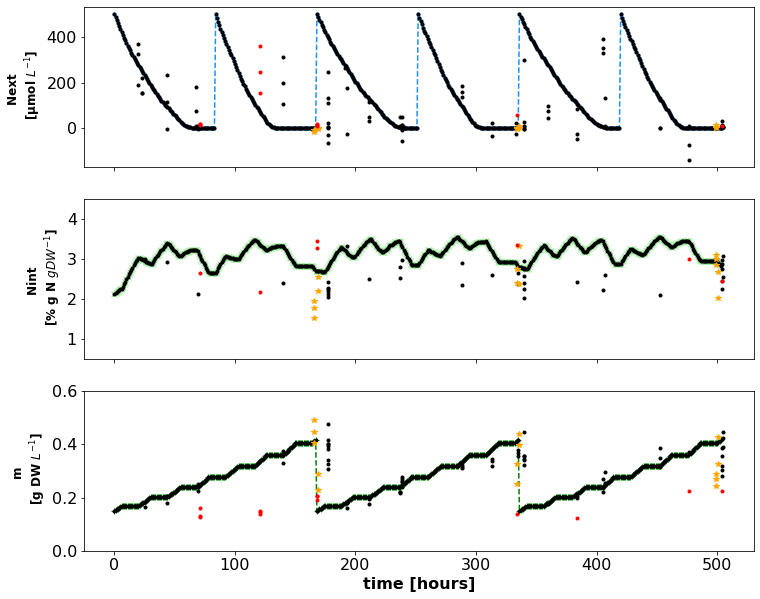

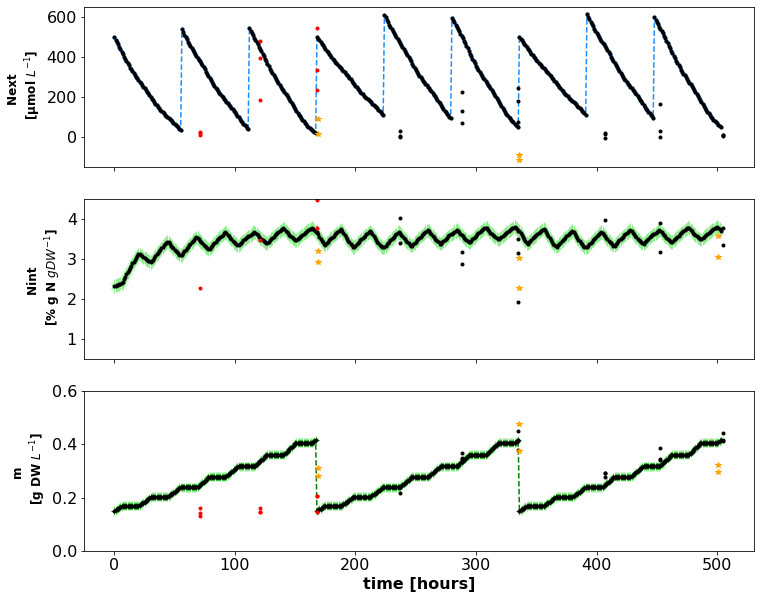

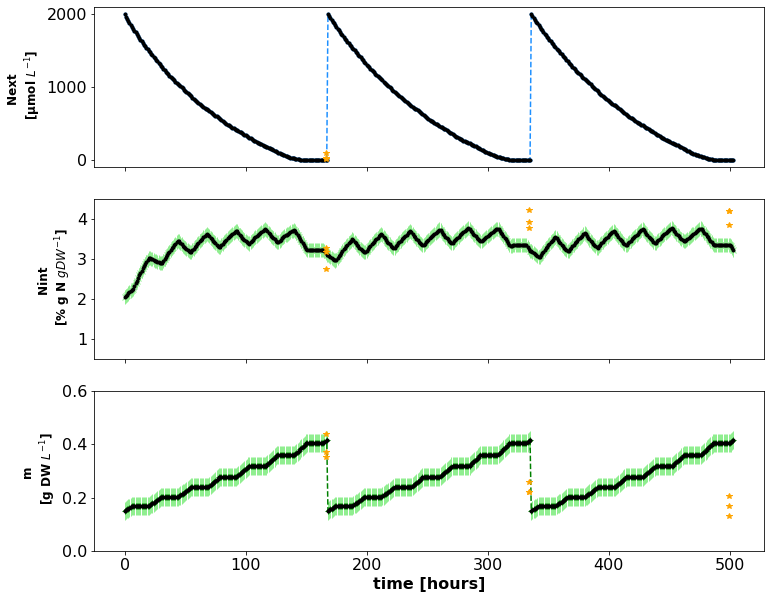

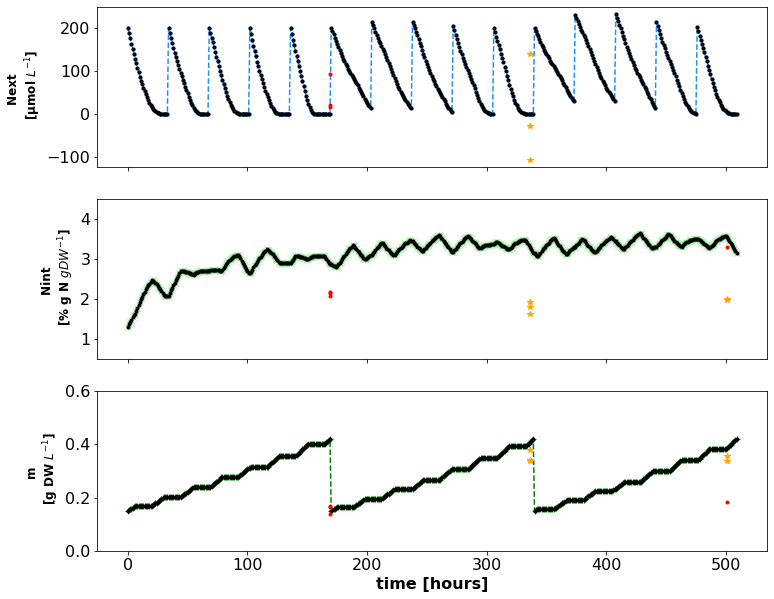

In [12]:
#n = 2
# Visual calibration of high resolution data (data from sporulation events was excluded)

# Calibration data - experiments #3 and #4 (black)
# Validation data - experiments #1, #2 and #5 (orange)


TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']
SDm_All = [0.0986,0.0796,0.0712,0.1023,0.0183] # two last SD values from validation
SEm_All = [0.0190,0.0098,0.0168,0.0341,0.0082] # two last SE values from validation
SDNint_All = [0.6547,0.3301,0.5822,0.5282,0.1577] 
SENint_All = [0.1502,0.0543,0.1681,0.1761,0.0705] 

Temp = 22
#I0 = 80
S = 39 # fix salinity function and S=40

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')&(df2.Comment != 'Exclude')]

df2_cal = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)]
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation')&(df2.Duration == 168) & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]


for i in Treatments:
    SEm = SEm_All[Treatments.index(i)]
    SENint = SENint_All[Treatments.index(i)]
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    mTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['DW']
    mTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['T']
    NintTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['N']
    NintTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['T']
    NextTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['NH4']
    NextTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude / Period / Duration parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    #T1 = '2019,02,14,17,0'
    #T2 = df3Temp['Timei']
    #T2 = T2.tolist()[0]
    #t0 = Time_to_Hours(T1,T2)
    
    # hour = 0 is 1pm (Meiron)
    # in the indoor settings we have to solve for shorter periods, 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the last Amplitude, 
    # m0 to the end of previous solution of ode()
    # 
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the iniital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 then replace the lines above with
    # the following line and then it will also give you a constant solution you had before
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
        t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

        x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)
    #Calibration experimental data
    mExpAllTimes_cal.append(mTimeTemp_cal)
    NintExpAllTimes_cal.append(NintTimeTemp_cal)
    NextExpAllTimes_cal.append(NextTimeTemp_cal)
    
    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    #Sporulation experimental data
    if len(mTimeTemp_spor) > 0: #np.empty(mTimeTemp_spor) != True:
        mExpAllTimes_spor.append(mTimeTemp_spor)
        NintExpAllTimes_spor.append(NintTimeTemp_spor)
        NextExpAllTimes_spor.append(NextTimeTemp_spor)
    
    #Validation model data
    #mModAll_val.append(m_model_val)
    #NintModAll_val.append(Nint_model_val)
    #NextModAll_val.append(Next_model_val) 
    
    #plot_result(t_model,Next_model,Nint_model,m_model,Nint=NintTemp,tNint=NintTimeTemp,m=mTemp,tm=mTimeTemp,Next=NextTemp,tNext=NextTimeTemp)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_val,tNint=NintTimeTemp_val,m=mTemp_val,tm=mTimeTemp_val,Next=NextTemp_val,tNext=NextTimeTemp_val)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val )
    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor,yerrm=SEm,yerrNint=SENint)

In [ ]:
# Calibration data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

mExpAllTimes_cal_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

In [ ]:
# Calibration data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        mSRE_All.append((((mexp.iloc[k]-mmod[k])/mmod[k])**2)) # All Square Relative Errors
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        NintSRE_All.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # All Square Relative Errors
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

In [ ]:

#0.154

In [ ]:

#0.232

In [ ]:
# Biomass model error of calibration data
RMSREmCal = round((np.mean(mSRE_All))**0.5,3)

# Nint model error of calibration data
RMSRENintCal = round((np.mean(NintSRE_All))**0.5,3)

# print errors:
print('Calibration data: ')
print('\nError of m is: ' + str(RMSREmCal))
print('\nError of Nint is: ' + str(RMSRENintCal))

# 0.15, 0.224
# 0.15, 0.224

In [ ]:
# Validation data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

#mExpAllTimes_cal_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

In [ ]:
# Validation data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        mSRE_All.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # All Square Relative Errors
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        NintSRE_All.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # All Square Relative Errors
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    #df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]
    #print('\nNext\n')
    #print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    #k = 0
    #for j in df2Next.Sample:
    #    Nextexp = df2Next.NH4
    #    if Nextexp.iloc[k] < 0:
    #        Nextexp.iloc[k] = 0
    #    Nextmod = NextModReducedAll[i]
    #    NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
    #    print('Sample #' + str(math.floor(float(j))))
    #    print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
    #    print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
    #    k = k + 1
    #RMSRENext = round((np.mean(NextSRE))**0.5,3)
    #NextSRE_All.append(NextSRE)
    #print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

In [ ]:
# Biomass model error of validation data

RMSREmVal = round((np.mean(mSRE_All))**0.5,3)

# Nint model error of validation data

RMSRENintVal = round((np.mean(NintSRE_All))**0.5,3)
#print(RMSRENintVal)

# print errors:
print('Validation data: ')
print('\nError of m is: ' + str(RMSREmVal))
print('\nError of Nint is: ' + str(RMSRENintVal))

In [ ]:
# print errors:
print('Calibration data: ')
print('\nError of m is: ' + str(RMSREmCal))
print('\nError of Nint is: ' + str(RMSRENintCal))

# 0.15, 0.224
# 0.15, 0.224
#0.15, 0.221

In [ ]:
#print(rp.summary_cont(df2_cal['DW']))
#print(rp.summary_cont(df2_cal['N']))
print(rp.summary_cont(df2_cal['DW'].groupby(df2_cal['Treatment'])))
print(rp.summary_cont(df2_cal['N'].groupby(df2_cal['Treatment'])))
#print(rp.summary_cont(df2_cal['N'].groupby(df2_cal['Treatment'])))


In [ ]:
print(rp.summary_cont(df2_val['DW'].groupby(df2_val['Treatment'])))
print(rp.summary_cont(df2_val['N'].groupby(df2_val['Treatment'])))

In [ ]:
print(rp.summary_cont(df2_spor['DW'].groupby(df2_spor['Treatment'])))
print(rp.summary_cont(df2_spor['N'].groupby(df2_spor['Treatment'])))